CIFAR10 dataset trained on all classes with 'normal' CNN without augmentation.

### Loading images
https://www.tensorflow.org/tutorials/load_data/images

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf

import numpy as np
import os
import pathlib
import matplotlib.pyplot as plt

# Some stuff to make utils-function work
import sys
sys.path.append('/home/henrik/master_thesis/code/utils')
from data_prep import create_dataset, print_class_info, show_image
%load_ext autoreload
%autoreload 2

# Jupyter-specific
%matplotlib inline

Some parameters

In [2]:
data_dir = pathlib.Path('/mnt/sdb/cifar10/train/')

config = {
    "data_dir": data_dir,
    "cache_dir": "./cache",
    "MODEL": 'cnn',
    "DS_INFO": 'complete',
    "resample": True,
    "neg_class": ['ship'],
    "NUM_EPOCHS": 5,
    "BATCH_SIZE": 64,
    "IMG_SIZE": (32, 32, 3),
    "outcast": None,
    "verbosity": 1
    }

model_name = '{}x{}x{}_{}_{}'.format(config["NUM_EPOCHS"], config["BATCH_SIZE"], 
                                     config["IMG_SIZE"][1], config["DS_INFO"], config["MODEL"])

Create training, testing and validation dataset from utils/data_prep.py

In [3]:
train_ds, test_ds, val_ds, params = create_dataset(config)

Directories:  ['cat' 'airplane' 'deer' 'automobile' 'ship' 'horse' 'truck' 'dog' 'bird'
 'frog']

cat               : 5000
airplane          : 5000
deer              : 5000
automobile        : 5000
ship              : 5000
horse             : 5000
truck             : 5000
dog               : 5000
bird              : 5000
frog              : 5000

Total number of images: 50000, in 10 classes
Dataset.list_files:  /mnt/sdb/cifar10/train/*/*.*g 

[1 2 1 8 2 8 4 3 0 3]
[1 1 4 5 4 4 7 7 9 8]
[7 4 7 7 2 8 3 5 1 8]
[8 7 9 5 8 8 9 0 9 1]
[5 4 4 6 0 8 3 4 4 3]
[5 2 1 7 1 7 5 8 1 7]
[4 2 5 4 1 2 5 5 0 0]
[5 9 5 9 2 9 1 0 5 0]
[4 7 6 4 2 0 9 5 7 0]
[1 6 0 8 5 2 6 4 9 9]

Full dataset sample size:        50000
Train dataset sample size:       35000
Test dataset sample size:         7500
Validation dataset sample size:   7500


## Training
### Normal CNN
See https://www.tensorflow.org/tutorials/images/cnn

In [4]:
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.layers import BatchNormalization

Create the model

In [5]:
cnn_model = models.Sequential()

cnn_model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=config["IMG_SIZE"]))
cnn_model.add(BatchNormalization())
cnn_model.add(layers.MaxPooling2D((2, 2)))

cnn_model.add(layers.Conv2D(64, (3, 3), activation='relu'))
cnn_model.add(BatchNormalization())
cnn_model.add(layers.MaxPooling2D((2, 2)))

cnn_model.add(layers.Conv2D(64, (3, 3), activation='relu'))
cnn_model.add(BatchNormalization())

cnn_model.add(layers.Flatten())
cnn_model.add(layers.Dense(64, activation='relu'))
cnn_model.add(layers.Dropout(0.2))
cnn_model.add(layers.Dense(params["NUM_CLASSES"], activation='softmax'))

In [6]:
if config["verbosity"] > 0:
    cnn_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 30, 32)        896       
_________________________________________________________________
batch_normalization (BatchNo (None, 30, 30, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 13, 13, 64)        18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 13, 13, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 4, 64)          3

Compile and train the model

In [7]:
opt = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)

cnn_model.compile(
                optimizer=opt,
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])

callbacks = [tf.keras.callbacks.TensorBoard(log_dir='./logs/{}'.format(model_name), update_freq='batch')]

In [8]:
history = cnn_model.fit(
        train_ds,
         steps_per_epoch = params["train_size"] // config["BATCH_SIZE"],
        epochs = config["NUM_EPOCHS"],
        validation_data = test_ds,
        validation_steps = params["test_size"] // config["BATCH_SIZE"],
        validation_freq = 1,
        callbacks = callbacks)

Train for 546 steps, validate for 117 steps
Epoch 1/5
546/546 [==============================] - 9s 17ms/step - loss: 1.5413 - accuracy: 0.4497 - val_loss: 1.5216 - val_accuracy: 0.4476
Epoch 2/5
546/546 [==============================] - 3s 6ms/step - loss: 1.1896 - accuracy: 0.5745 - val_loss: 1.2699 - val_accuracy: 0.5553
Epoch 3/5
546/546 [==============================] - 3s 5ms/step - loss: 1.0345 - accuracy: 0.6334 - val_loss: 0.9605 - val_accuracy: 0.6635
Epoch 4/5
546/546 [==============================] - 3s 5ms/step - loss: 0.9248 - accuracy: 0.6730 - val_loss: 1.1182 - val_accuracy: 0.6151
Epoch 5/5
546/546 [==============================] - 3s 5ms/step - loss: 0.8482 - accuracy: 0.6992 - val_loss: 0.8347 - val_accuracy: 0.7143


In [9]:
# cnn_model.save('models/{}.h5'.format(model_name))
# cnn_model = tf.keras.models.load_model('models/{}.h5'.format(model_name))

## Evaluate the model

In [10]:
cnn_evaluate = cnn_model.evaluate(val_ds, verbose=2, steps=params["val_size"] // config["BATCH_SIZE"])

117/117 - 4s - loss: 0.8299 - accuracy: 0.7133


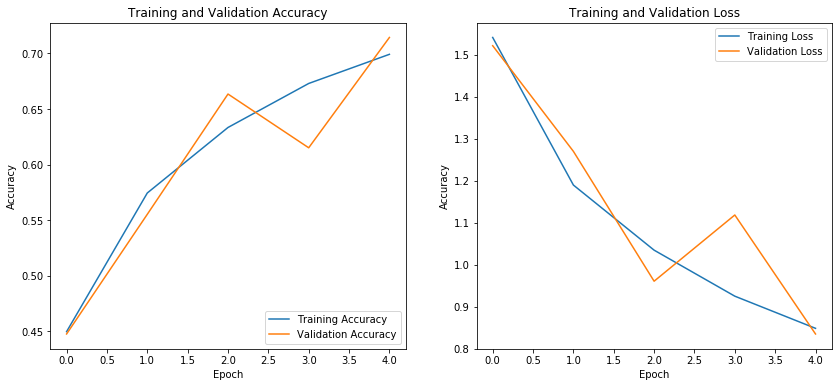

In [11]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(config["NUM_EPOCHS"])

plt.figure(figsize=(14, 6))

# Subplot 1
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
# plt.ylim([0.5, 1])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')

# Subplot 2
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
# plt.ylim([0.5, 1])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Loss')
plt.show()

`Tensorboard`

## Predict new samples

In [12]:
# Fetch one batch
images, labels = next(iter(val_ds))

# Convert from tensor to numpy array
images = images.numpy()
labels = labels.numpy()

0.0000 cat
0.0000 airplane
0.0000 deer
0.9993 automobile
0.0000 ship
0.0000 horse
0.0007 truck
0.0000 dog
0.0000 bird
0.0000 frog

Label: automobile
Predicton: automobile


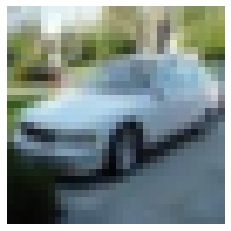

In [13]:
# Get a random image and label
rand = np.random.randint(0, config["BATCH_SIZE"])
image = images[rand]
label = labels[rand]

# Predict one image
predictions = cnn_model.predict(np.expand_dims(image, axis=0))[0]

for i, pred in enumerate(predictions):
    print("{:0.4f} {}".format(pred,params["class_names"][i]))

print ("\nLabel:", params["class_names"][label])
print ("Predicton:", params["class_names"][np.argmax(predictions)])

plt.figure(frameon=False, facecolor='white')
plt.imshow(image)
plt.axis('off');

In [14]:
# Predict one batch
predictions = cnn_model.predict(images)

print ('{:3}  {:10}  {:3}'.format('idx', 'label', 'pred'))
print ('---  -------     --------')

for i, pred in enumerate(predictions):
    label = params["class_names"][labels[i]]
    prediction = params["class_names"][np.argmax(pred)]
    print ('\n{:3}  {:10}  {:10}'.format(i, label, prediction), end='')
    if (label != prediction): print ("  Wrong", end='')

idx  label       pred
---  -------     --------

  0  dog         cat         Wrong
  1  frog        frog      
  2  airplane    airplane  
  3  cat         cat       
  4  cat         bird        Wrong
  5  bird        airplane    Wrong
  6  bird        frog        Wrong
  7  frog        frog      
  8  bird        cat         Wrong
  9  horse       horse     
 10  automobile  automobile
 11  ship        ship      
 12  frog        frog      
 13  frog        frog      
 14  ship        ship      
 15  bird        frog        Wrong
 16  deer        deer      
 17  automobile  automobile
 18  bird        bird      
 19  ship        truck       Wrong
 20  horse       horse     
 21  deer        horse       Wrong
 22  deer        horse       Wrong
 23  bird        deer        Wrong
 24  truck       truck     
 25  cat         cat       
 26  horse       horse     
 27  truck       ship        Wrong
 28  deer        deer      
 29  airplane    airplane  
 30  frog        frog      
 31  a